In [235]:
import numpy as np
import matplotlib.pyplot as plt


# Data Creation

In [236]:
fundamental_freq = 8000
number_of_data_points = 100

source1_freq = np.random.uniform(0,fundamental_freq,number_of_data_points).reshape(-1,1)
source2_freq = np.random.uniform(fundamental_freq,2*fundamental_freq,number_of_data_points).reshape(-1,1)

sample_rate = 44100
timesteps = 10000

samples = np.linspace(0,timesteps/sample_rate , timesteps, endpoint=False)

source1_sin = np.sin(2*np.pi*source1_freq*samples)

source2_sin = np.sin(2*np.pi*source2_freq *samples)

mixed = source1_sin + source2_sin


In [237]:
mixed.shape

(100, 10000)

<Figure size 1200x800 with 0 Axes>

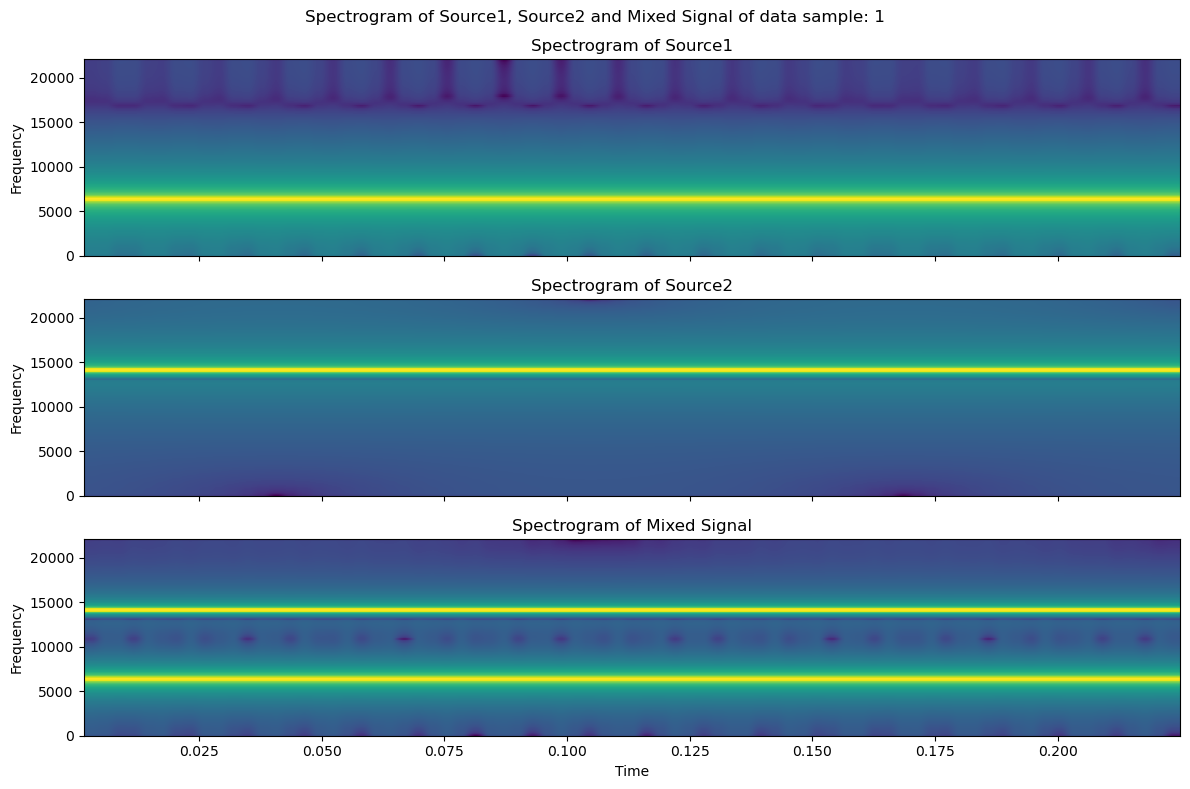

In [238]:
plt.figure(figsize=(12, 8))
data_sample = 1

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Plot spectrogram of source1
axs[0].specgram(source1_sin[data_sample].flatten(), Fs=sample_rate)
axs[0].set_title('Spectrogram of Source1')
axs[0].set_ylabel('Frequency')

# Plot spectrogram of source2
axs[1].specgram(source2_sin[data_sample].flatten(), Fs=sample_rate)
axs[1].set_title('Spectrogram of Source2')
axs[1].set_ylabel('Frequency')

# Plot spectrogram of mixed signal
axs[2].specgram(mixed[data_sample].flatten(), Fs=sample_rate)
axs[2].set_title('Spectrogram of Mixed Signal')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')
plt.suptitle(f'Spectrogram of Source1, Source2 and Mixed Signal of data sample: {data_sample}')
plt.tight_layout()
plt.show()


In [320]:
import torch
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, mixed_signal, source1_signal, source2_signal):
        self.mixed_signal = mixed_signal
        self.source1_signal = source1_signal
        self.source2_signal = source2_signal

    def __len__(self):
        return len(self.mixed_signal)

    def __getitem__(self, idx):
        mixed = self.mixed_signal[idx]
        source1 = self.source1_signal[idx]
        source2 = self.source2_signal[idx]
        return mixed.reshape(1,-1).astype(np.float32), source1.astype(np.float32), source2.astype(np.float32)

def collate_fn(batch):
    mixes, source1, source2 = zip(*batch)
    mixes = torch.stack(torch.from_numpy(mixes))
    source1 = torch.stack(torch.from_numpy(source1))
    source2 = torch.stack(torch.from_numpy(source2))

    return mixes, source1, source2

train_ratio = 0.9
test_ratio = 0.1

# Create the dataset
dataset = AudioDataset(mixed, source1_sin, source2_sin)
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print("Training set length:", len(train_dataset))
print("Testing set length:", len(test_dataset))


Training set length: 90
Testing set length: 10


In [401]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,dropout=0.3,proj_size=hidden_size//2)
        self.fc = nn.Linear(hidden_size//2, output_size)
    
    def forward(self, x):
        
        out,_ = self.lstm(x)
        F.layer_norm(out, out.size()[1:])
        out = out.flatten(start_dim=1)
        out = self.fc(out)
        
        return out

input_size = 10000  
hidden_size = 64
num_layers = 1
output_size = 10000*2  




In [402]:
torch.cuda.empty_cache()

LSTMModel(
  (lstm): LSTM(10000, 64, proj_size=32, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=32, out_features=20000, bias=True)
)


100%|██████████| 3/3 [00:00<00:00, 15.30it/s]


Epoch [1/10], Average Loss: 1.3058130741119385, Average SI-SNR: -46.84598032633463


100%|██████████| 3/3 [00:00<00:00, 69.20it/s]


Epoch [2/10], Average Loss: 1.3411451975504558, Average SI-SNR: -27.047021865844727


100%|██████████| 3/3 [00:00<00:00, 83.72it/s]


Epoch [3/10], Average Loss: 1.267200271288554, Average SI-SNR: -17.339903831481934


100%|██████████| 3/3 [00:00<00:00, 88.36it/s]


Epoch [4/10], Average Loss: 1.1999433437983196, Average SI-SNR: -11.68655268351237


100%|██████████| 3/3 [00:00<00:00, 86.96it/s]


Epoch [5/10], Average Loss: 1.1551483869552612, Average SI-SNR: -9.636962254842123


100%|██████████| 3/3 [00:00<00:00, 85.70it/s]


Epoch [6/10], Average Loss: 1.1201010942459106, Average SI-SNR: -8.437266031901041


100%|██████████| 3/3 [00:00<00:00, 105.12it/s]


Epoch [7/10], Average Loss: 1.1045127709706624, Average SI-SNR: -7.918673038482666


100%|██████████| 3/3 [00:00<00:00, 90.02it/s]


Epoch [8/10], Average Loss: 1.0711113214492798, Average SI-SNR: -6.942829449971517


100%|██████████| 3/3 [00:00<00:00, 50.96it/s]


Epoch [9/10], Average Loss: 1.0612460374832153, Average SI-SNR: -6.616633415222168


100%|██████████| 3/3 [00:00<00:00, 47.15it/s]


Epoch [10/10], Average Loss: 1.040048082669576, Average SI-SNR: -6.119852542877197


100%|██████████| 1/1 [00:00<00:00, 159.04it/s]


Average Loss: 1.4341650009155273, Average SI-SNR: -49.146881103515625


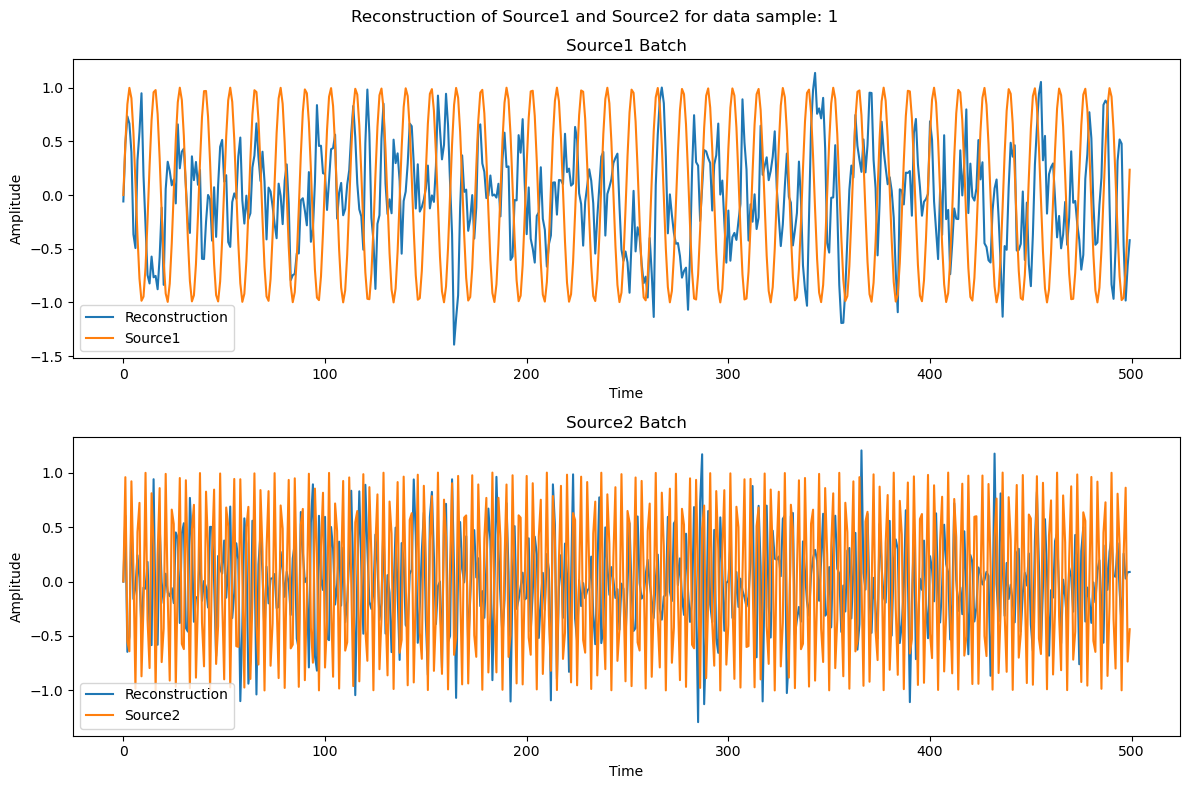

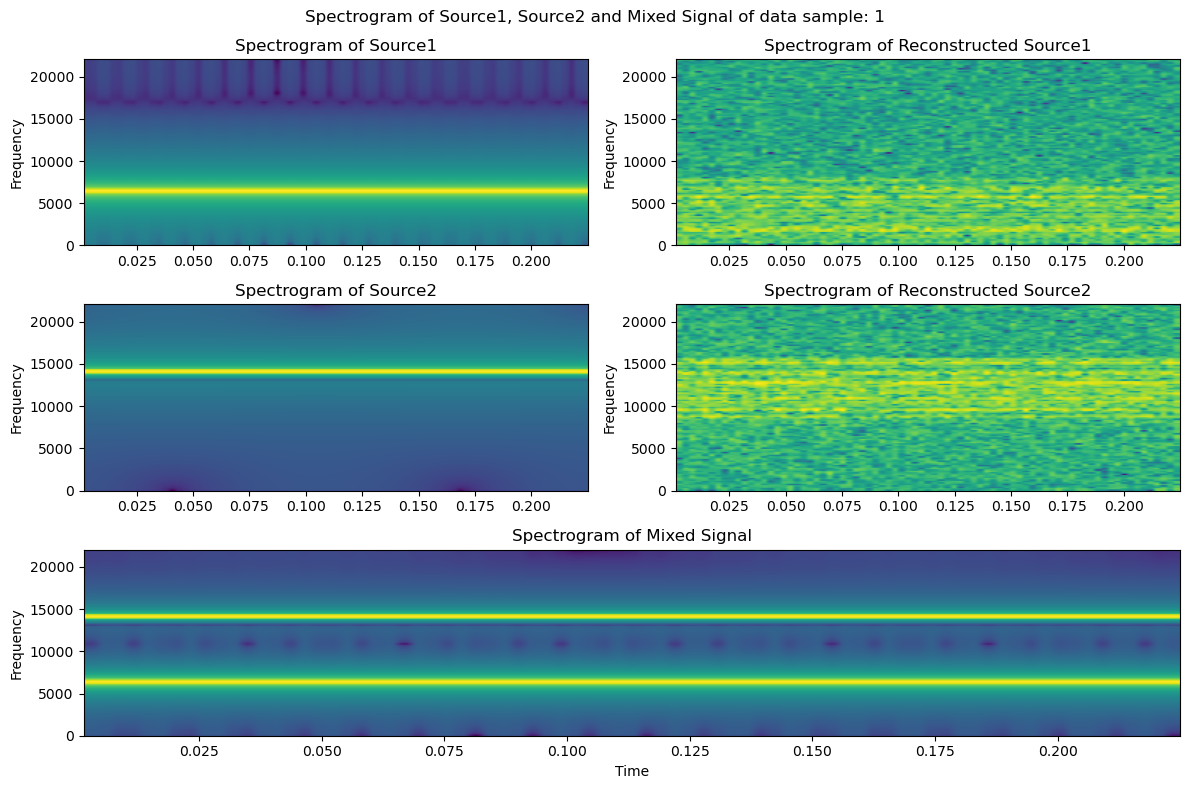

In [420]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.audio import ScaleInvariantSignalNoiseRatio as SI_SNR
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


loss_fn = nn.L1Loss()
si_snr = SI_SNR().to(device)

model = LSTMModel(input_size, hidden_size, num_layers, output_size)


print(model)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.1,weight_decay=1e-5,)

num_epochs = 10

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Training loop
for epoch in range(num_epochs):
    avg_loss = 0
    avg_metric = 0
    # Iterate over the dataset
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        # Move the data to the device

        mixed_batch, source1_batch, source2_batch = (i.to(device) for i in batch)
        # print(mixed.shape)
        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(mixed_batch)
        outputs1 = outputs[:,0:10000]
        outputs2 = outputs[:,10000:]
        # Calculate the loss
        loss1 = loss_fn(outputs1, source1_batch)
        loss2 = loss_fn(outputs2, source2_batch)
        loss = loss1 + loss2

        # Backward pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Calculate the SI-SNR metric
        snr1 = si_snr(source1_batch, outputs1)
        snr2 = si_snr(source2_batch, outputs2)
        snr = (snr1 + snr2)/2

        # Update the average loss and metric
        avg_loss += loss.item()
        avg_metric += snr.item()

    # Calculate the average loss and metric for the epoch
    avg_loss /= len(train_loader)
    avg_metric /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss}, Average SI-SNR: {avg_metric}")




# Evaluation loop
model.eval()
avg_loss = 0
avg_metric = 0
with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        # Move the data to the device
        mixed_batch, source1_batch, source2_batch = (i.to(device) for i in batch)

        # Forward pass
        outputs = model(mixed_batch)
        outputs1 = outputs[:,0:10000]
        outputs2 = outputs[:,10000:]
        # Calculate the loss
        loss1 = loss_fn(outputs1, source1_batch)
        loss2 = loss_fn(outputs2, source2_batch)
        loss = loss1 + loss2

        # Calculate the SI-SNR metric
        snr1 = si_snr(source1_batch, outputs1)
        snr2 = si_snr(source2_batch, outputs2)
        snr = (snr1 + snr2)/2

        # Update the average loss and metric
        avg_loss += loss.item()
        avg_metric += snr.item()

    # Calculate the average loss and metric for the test set
    avg_loss /= len(test_loader)
    avg_metric /= len(test_loader)
    print(f"Average Loss: {avg_loss}, Average SI-SNR: {avg_metric}")
data_sample = 1

plt.figure(figsize=(12, 8))

# Plot output1 (reconstruction of source1_batch)
plt.subplot(2, 1, 1)
plt.plot(outputs1[data_sample].flatten().cpu().detach().numpy()[0:500])
plt.title('Reconstruction of Source1')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot source1_batch
# plt.subplot(2, 2, 2)
plt.plot(source1_batch[data_sample].flatten().cpu().detach().numpy()[0:500])
plt.title('Source1 Batch')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.legend(['Reconstruction', 'Source1'])
# Plot output2 (reconstruction of source2_batch)
plt.subplot(2, 1, 2)
plt.plot(outputs2[data_sample].flatten().cpu().detach().numpy()[0:500])
plt.title('Reconstruction of Source2')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot source2_batch
# plt.subplot(2, 2, 2)
plt.plot(source2_batch[data_sample].flatten().cpu().detach().numpy()[0:500])
plt.title('Source2 Batch')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(['Reconstruction', 'Source2'])
plt.suptitle(f'Reconstruction of Source1 and Source2 for data sample: {data_sample}')
plt.tight_layout()
plt.show()



from matplotlib.gridspec import GridSpec
fig = plt.figure(layout="constrained",figsize=(12, 8))

gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :-1])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[0, 1:])
ax3 = fig.add_subplot(gs[1, :-1])
ax4 = fig.add_subplot(gs[1, 1:])
ax5 = fig.add_subplot(gs[2, :])

ax1.specgram(source1_sin[data_sample].flatten(), Fs=sample_rate)
ax1.set_title('Spectrogram of Source1')
ax1.set_ylabel('Frequency')

ax2.specgram(outputs1[data_sample].flatten().cpu().detach().numpy(), Fs=sample_rate)
ax2.set_title('Spectrogram of Reconstructed Source1')
ax2.set_ylabel('Frequency')

ax3.specgram(source2_sin[data_sample].flatten(), Fs=sample_rate)
ax3.set_title('Spectrogram of Source2')
ax3.set_ylabel('Frequency')

ax4.specgram(outputs2[data_sample].flatten().cpu().detach().numpy(), Fs=sample_rate)
ax4.set_title('Spectrogram of Reconstructed Source2')
ax4.set_ylabel('Frequency')

ax5.specgram(mixed[data_sample].flatten(), Fs=sample_rate)
ax5.set_title('Spectrogram of Mixed Signal')
ax5.set_xlabel('Time')
ax5.set_ylabel('Frequency')

plt.suptitle(f'Spectrogram of Source1, Source2 and Mixed Signal of data sample: {data_sample}')
plt.tight_layout()
plt.show()
